# Hepstat_Tutorial_Roofit_Extended
Fit examples with RooFit, composite p.d.f with signal and background component, extended
```
pdf = n_bkg * bkg(x,a0,a1) + n_sig * (f_sig1 * sig1(x,m,s1 + (1-f_sig1) * sig2(x,m,s2)))
or using a signal strength
pdf = n_bkg * bkg(x,a0,a1) + mu * n_sig * (f_sig1 * sig1(x,m,s1 + (1-f_sig1) * sig2(x,m,s2)))
```
 with following objectives:
 * Compare plain likelihood fit and profile likelihood fit
 * Fit with nuisance parameters with constraints


Modified from [rf201_composite.py](https://root.cern/doc/master/rf201__composite_8py.html)


**Author:** Lailin XU  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Monday, March 29, 2021 at 04:15 PM.</small></i>

Import the ROOT libraries

In [1]:
import ROOT as R
from math import pow, sqrt
R.gROOT.SetStyle("ATLAS")

Welcome to JupyROOT 6.22/07


Setup component pdfs
---------------------------------------

Declare observable x

  [RooRealVar](https://root.cern.ch/doc/master/classRooRealVar.html) (const char *name, const char *title, Double_t minValue, Double_t maxValue, const char *unit="")

In [2]:
x = R.RooRealVar("x", "x", 0, 10)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Create two Gaussian PDFs g1(x,mean1,sigma) anf g2(x,mean2,sigma) and
their parameters

In [3]:
mean = R.RooRealVar("mean", "mean of gaussians", 5)
sigma1 = R.RooRealVar("sigma1", "width of gaussians", 0.5)
sigma2 = R.RooRealVar("sigma2", "width of gaussians", 1)

sig1 = R.RooGaussian("sig1", "Signal component 1", x, mean, sigma1)
sig2 = R.RooGaussian("sig2", "Signal component 2", x, mean, sigma2)

Build Chebychev polynomial p.d.f.

In [4]:
a0 = R.RooRealVar("a0", "a0", 0.5, 0., 1.)
a1 = R.RooRealVar("a1", "a1", -0.2, 0., 1.)
bkg = R.RooChebychev("bkg", "Background", x, R.RooArgList(a0, a1))

Normalization of the components

In [5]:
nsig_norm = R.RooRealVar("nsig_norm", "number of signal events", 500, 0., 10000)
mu_sig = R.RooRealVar("mu_sig", "signal strength", 1, 0, 100.)
mu_sig.setConstant(1)
nsig = R.RooProduct("nsig", "number of signal events", R.RooArgList(nsig_norm, mu_sig))
nbkg = R.RooRealVar("nbkg", "number of background events", 500, 0, 10000)

Full model: the total PDF
------------------------------------------
Sum the signal components into a composite signal p.d.f.. Here we use [RooAddPdf](https://root.cern.ch/doc/master/classRooAddPdf.html)
  RooAddPdf (const char *name, const char *title, const RooArgList &pdfList, const RooArgList &coefList, Bool_t recursiveFraction=kFALSE)

In [6]:
sig1frac = R.RooRealVar("sig1frac", "fraction of component 1 in signal", 0.8, 0., 1.)
sig = R.RooAddPdf("sig", "Signal", R.RooArgList(sig1, sig2), R.RooArgList(sig1frac))

Sum the composite signal and background

In [7]:
model = R.RooAddPdf("model", "g1+g2+a", R.RooArgList(bkg, sig), R.RooArgList(nbkg, nsig))

A quick look at the model

In [8]:
model.Print()

RooAddPdf::model[ nbkg * bkg + nsig * sig ] = 1


Sample, fit and plot model
---------------------------------------------------

In [9]:
myc = R.TCanvas("c", "c", 800, 600)
myc.SetFillColor(0)
myc.cd()

Generate a toy data sample of 1000 events in x from model

 [RooAbsPdf::generate](https://root.cern.ch/doc/master/classRooAbsPdf.html), this will generate *unbinned* data, see [RooDataSet](https://root.cern.ch/doc/master/classRooDataSet.html)

In [10]:
data = model.generate(R.RooArgSet(x), 100)

Fit model to data

In [11]:
model.fitTo(data)

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (sig1,sig2)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bkg)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           5.00000e-01  1.00000e-01    0.00000e+00  1.00000e+00
     2 a1           0.00000e+00  1.00000e-01    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAM DEF
 ============== STARTING VALUE IS AT LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 IS AT ITS LOWER ALLOWED LIMIT.
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 BROUGHT BACK INSIDE LIMITS.
     3 n

Plot data and PDF overlaid

In [12]:
xframe = x.frame(R.RooFit.Title("Example of composite pdf=(sig1+sig2)+bkg"))
data.plotOn(xframe, R.RooFit.Name('Data'))
model.plotOn(xframe, R.RooFit.Name('Full_Model'), R.RooFit.LineColor(R.kBlue))
xframe.Draw()
ymax = xframe.GetMaximum()
xframe.SetMaximum(ymax*1.2)

Overlay the background component of model with a dashed line

In [13]:
ras_bkg = R.RooArgSet(bkg)
model.plotOn(xframe, R.RooFit.Components(ras_bkg), R.RooFit.LineStyle(R.kDashed), R.RooFit.LineColor(R.kRed), R.RooFit.Name('Bkg'))
xframe.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Overlay the signal components of model with a dotted line

In [14]:
ras_sig1 = R.RooArgSet(sig1)
model.plotOn(xframe, R.RooFit.Components(ras_sig1), R.RooFit.LineStyle(R.kDotted), R.RooFit.LineColor(R.kMagenta), R.RooFit.Name('Sig1'))
xframe.Draw()
ras_sig2 = R.RooArgSet(sig2)
model.plotOn(xframe, R.RooFit.Components(ras_sig2), R.RooFit.LineStyle(R.kDotted), R.RooFit.LineColor(R.kGreen+2), R.RooFit.Name('Sig2'))
xframe.Draw()

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (sig1)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (sig)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (sig2)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (sig)


Overlay the background+sig2 components of model with a dotted line

In [15]:
ras_bkg_sig2 = R.RooArgSet(bkg, sig2)
model.plotOn(xframe, R.RooFit.Components(ras_bkg_sig2), R.RooFit.LineStyle(R.kDotted), R.RooFit.LineColor(R.kCyan), R.RooFit.Name('Sig2Bkg'))

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (bkg,sig2)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: (sig)


Draw legends

In [16]:
lIy = 0.92
lg = R.TLegend(0.60, lIy-0.25, 0.85, lIy)
lg.SetBorderSize(0)
lg.SetFillStyle(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.AddEntry(xframe.findObject("Data"), 'Data', 'p')
lg.AddEntry(xframe.findObject("Full_Model"), 'Full model (Sig1+Sig2+Bkg)', 'l')
lg.AddEntry(xframe.findObject("Bkg"), 'Bkg', 'l')
lg.AddEntry(xframe.findObject("Sig1"), 'Sig1', 'l')
lg.AddEntry(xframe.findObject("Sig2"), 'Sig2', 'l')
lg.Draw("same")

Show fit results in the canvas

In [17]:
xlab0, ylab0=0.18, 0.90
fv1 = R.TPaveText(xlab0, ylab0, xlab0+0.20, 0.75,"NDC")
fv1.SetBorderSize(0)
fv1.SetFillStyle(0)
fv1.SetTextAlign(11)
fv1.SetTextSize(0.030)
fv1.AddText("{0:s} = {1:.2f} #pm {2:.2f}".format(nbkg.GetTitle(), nbkg.getVal(), nbkg.getError()))
fv1.AddText("{0:s} = {1:.2f} #pm {2:.2f}".format(nsig_norm.GetTitle(), nsig_norm.getVal(), nsig_norm.getError()))
fv1.Draw("same")

myc.Update()
myc.SaveAs("test_roofit_extended_1.png")

Info in <TCanvas::Print>: png file test_roofit_extended_1.png has been created


Fit the signal strength
---------------------------------------------------
Set the signal normalization as a constant, using the above fit result

In [18]:
nsig_norm.setConstant(1)
mu_sig.setConstant(0)

model.fitTo(data)

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (sig1,sig2)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (bkg)
 **********
 **   10 **SET PRINT           1
 **********
 **********
 **   11 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 a0           5.44102e-01  1.99493e-01    0.00000e+00  1.00000e+00
     2 a1           8.74154e-06  6.13685e-01    0.00000e+00  1.00000e+00
 MINUIT WARNING IN PARAMETR
 ============== VARIABLE2 BROUGHT BACK INSIDE LIMITS.
     3 mu_sig       1.00000e+00  5.00000e-01    0.00000e+00  1.00000e+02
     4 nbkg         4.43404e+01  8.30307e+00    0.00000e+00  1.00000e+04
     5 sig1frac     

Plot the NLL scan and Profile NLL scan
---------------------------------------------------

Let's be realistic, set some sensible ranges for all free parameters

In [19]:
mu_sig.setRange(0, 2.)
a0.setRange(a0.getVal() - a0.getError(), a0.getVal() + a0.getError())
a1.setRange(a1.getVal() - a1.getError(), a1.getVal() + a1.getError())

plain NLL, see [RooAbsPdf::createNLL](https://root.cern.ch/doc/master/classRooAbsPdf.html)

In [20]:
nll = model.createNLL(data, R.RooFit.NumCPU(2)) # use 2 CPU cores to speed up

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.


Profile NLL (PLL), see [RooAbsReal::createProfile](https://root.cern.ch/doc/master/classRooAbsReal.html)
  RooAbsReal::createProfile(const RooArgSet & paramsOfInterest)

In [21]:
pll = nll.createProfile(mu_sig)

myc.Clear()
mframe = mu_sig.frame(R.RooFit.Title("NLL scan"))

Plot NLL and PLL

In [22]:
nll.plotOn(mframe, R.RooFit.ShiftToZero(), R.RooFit.LineColor(R.kBlue), R.RooFit.Name('NLL'))

[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 2 remote server process.


*BE CAUTIONS* scanning a PLL is much slower as it does minimization at each step

In [23]:
pll.plotOn(mframe, R.RooFit.LineColor(R.kRed), R.RooFit.Name('PLL'), R.RooFit.Precision(1) )

mframe.SetMinimum(0)
mframe.SetMaximum(30.)
mframe.Draw()

lg.Clear()
lg.AddEntry(mframe.findObject("NLL"), 'Plain negative llh', 'l')
lg.AddEntry(mframe.findObject("PLL"), 'Profile nll', 'l')
lg.Draw("same")

myc.Update()
myc.SaveAs("test_roofit_extended_2.png")

[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[mu_sig]) Creating instance of MINUIT
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[mu_sig]) determining minimum likelihood for current configurations w.r.t all observable
[#1] INFO:Eval -- RooAbsTestStatistic::initMPMode: started 2 remote server process.
[#1] INFO:Minization -- RooProfileLL::evaluate(nll_model_modelData_Profile[mu_sig]) minimum found at (mu_sig=1.07992)
..........................................................................................................................................................................................................

Info in <TCanvas::Print>: png file test_roofit_extended_2.png has been created


Draw all canvases 

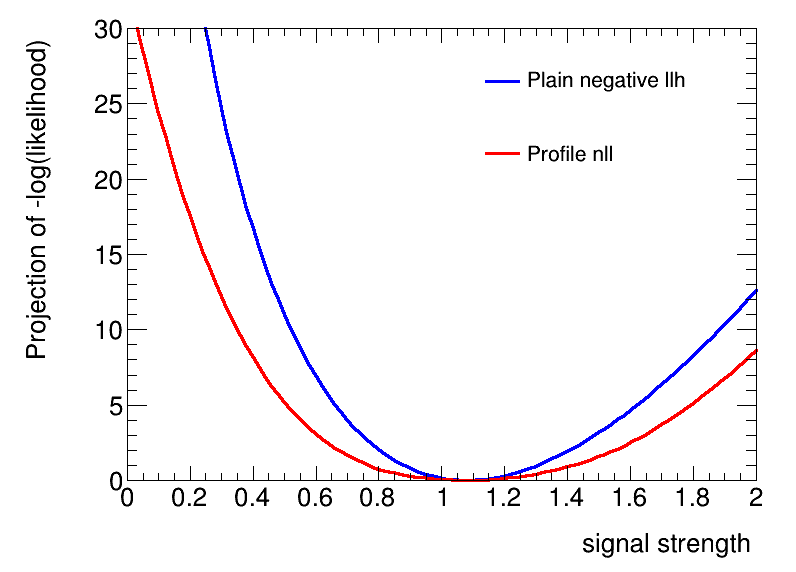

In [24]:
from ROOT import gROOT 
gROOT.GetListOfCanvases().Draw()